# UNet Inference Notebook

This notebook:
- Re-defines the UNet model (copied from `UNet.ipynb`)
- Loads one CFDBench `bc/` example
- Visualizes one raw sample (u, v, mask)
- Loads `checkpoints/latest_model.pth`
- Runs inference and visualizes prediction vs ground truth


In [ ]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


from typing import Tuple, List, Dict, Any, Optional
import random
import json

# --- 1. Placeholder/Base Classes (Required for the function definition) ---

# Mock base classes - assume full implementation is elsewhere
class CfdDataset: pass
class CfdAutoDataset: pass

# Mock implementation of the CylinderFlowAutoDataset class
class CylinderFlowAutoDataset(CfdAutoDataset):
    data_delta_time = 0.001
    
    def __init__(self, case_dirs: List[Path], split: str, **kwargs):
        self.case_dirs = case_dirs
        self.split = split
        # Mock parameter to easily display which cases were loaded
        self.case_names = [p.name for p in case_dirs]
        
        # Load data is mocked to avoid file system dependency in this example
        self.time_step_size = int(kwargs.get('delta_time', 0.01) / self.data_delta_time)
        self.load_data(case_dirs, self.time_step_size)

    def load_data(self, case_dirs, time_step_size: int):
        print(f"  [Loader]: Processing data for split '{self.split}' from {len(case_dirs)} case(s).")
        
        if not case_dirs:
            raise ValueError("No case directories provided")
        
        # Initialize lists to store data for all cases
        self.u_data = []
        self.v_data = []
        self.case_params = []  # Store JSON metadata for each case
        
        # Use first 620 timesteps for consistency across all cases
        max_timesteps = 620
        
        # Process all cases
        for case_dir in case_dirs:
            u_path = case_dir / "u.npy"
            v_path = case_dir / "v.npy"
            
            # Check if files exist
            if not u_path.exists():
                raise FileNotFoundError(f"u.npy not found in {case_dir}")
            if not v_path.exists():
                raise FileNotFoundError(f"v.npy not found in {case_dir}")
            
            # Load data
            u_data = np.load(u_path)
            v_data = np.load(v_path)
            
            # Validate u and v have matching shapes
            if u_data.shape != v_data.shape:
                raise ValueError(
                    f"Shape mismatch in {case_dir}: u.npy shape {u_data.shape} != v.npy shape {v_data.shape}"
                )
            
            # Truncate to first max_timesteps if needed
            original_timesteps = u_data.shape[0]
            if original_timesteps > max_timesteps:
                u_data = u_data[:max_timesteps]
                v_data = v_data[:max_timesteps]
                print(f"    ⚠ {case_dir.name}: Truncated from {original_timesteps} to {max_timesteps} timesteps")
            elif original_timesteps < max_timesteps:
                print(f"    ⚠ {case_dir.name}: Only {original_timesteps} timesteps available (less than {max_timesteps})")
            
            # Ensure spatial dimensions match expected (64x64)
            if len(u_data.shape) == 3 and u_data.shape[1:] != (64, 64):
                raise ValueError(
                    f"Spatial dimension mismatch in {case_dir}: expected (T, 64, 64), got {u_data.shape}"
                )
            
            # Store the data in memory
            self.u_data.append(u_data)
            self.v_data.append(v_data)
            
            # Load JSON metadata
            json_path = case_dir / "case.json"
            if json_path.exists():
                with open(json_path, 'r') as f:
                    case_params = json.load(f)
                self.case_params.append(case_params)
            else:
                raise FileNotFoundError(f"case.json not found in {case_dir}")
            
            print(f"    ✓ {case_dir.name}: u.npy shape {u_data.shape}, v.npy shape {v_data.shape}, params: {case_params}")
        
        # Store detected shape (using actual shape from first case after truncation)
        if self.u_data:
            self.data_shape = self.u_data[0].shape
            print(f"  [Loader]: Using data shape: {self.data_shape} (time_steps={self.data_shape[0]}, spatial={self.data_shape[1]}x{self.data_shape[2]})")
        
        # Mock tensors/params to fulfill internal requirements
        self.inputs = torch.randn(10, 3, 64, 64) 
        self.labels = torch.randn(10, 3, 64, 64) 
        self.case_ids = [0] * 10


# --- 2. The Modified Dataset Loading Function ---

def get_cylinder_auto_datasets(
    data_dir: Path,
    subset_name: str,
    norm_props: bool,
    norm_bc: bool,
    delta_time: float = 0.01,
    stable_state_diff: float = 0.001,
    seed: int = 0,
    load_splits: List[str] = ["train", "dev", "test"],
    case_fraction: float = 1.0, 
) -> Tuple[
    Optional[CylinderFlowAutoDataset],
    Optional[CylinderFlowAutoDataset],
    Optional[CylinderFlowAutoDataset],
]:
    # Check if data directory exists
    data_dir = Path(data_dir).resolve()
    if not data_dir.exists():
        raise FileNotFoundError(f"Data directory not found: {data_dir}. Please check the path.")
    
    print(f"\nSearching in subset: {subset_name}")
    print(f"Data directory: {data_dir}")
    
    case_dirs = []
    
    # Case collection: only loads cases from the specified subset_name (e.g., 'bc')
    for name in ["prop", "bc", "geo"]:
        if name == subset_name:
            case_dir = data_dir / name
            if not case_dir.exists():
                raise FileNotFoundError(f"Subset directory not found: {case_dir}. Check data_dir path.")
            # Glob all cases and sort them numerically
            this_case_dirs = sorted(
                case_dir.glob("case*"), key=lambda x: int(x.name[4:])
            )
            case_dirs += this_case_dirs

    assert case_dirs, f"No cases found in {data_dir}/{subset_name}. Check data_dir path."

    random.seed(seed)
    random.shuffle(case_dirs)

    # 🌟 LOGIC TO SELECT FRACTION OF CASES
    num_cases_total = len(case_dirs)
    if case_fraction < 1.0:
        num_cases_to_use = int(num_cases_total * case_fraction)
        
        # Ensure at least one case is selected
        if num_cases_to_use == 0 and num_cases_total > 0:
            num_cases_to_use = 1 

        case_dirs = case_dirs[:num_cases_to_use]
        print(f"Loading partial data: Using {num_cases_to_use} out of {num_cases_total} total cases ({case_fraction*100:.2f}%)")

    # Split into train, dev, test
    num_cases = len(case_dirs)
    num_train = int(num_cases * 0.8)
    num_dev = int(num_cases * 0.1)
    
    # Adjust split for single case load (forces 1 Train, 0 Dev, 0 Test)
    if num_cases == 1:
        num_train, num_dev = 1, 0
    elif num_cases >= 2:
        if num_train + num_dev == num_cases: 
            num_dev -= 1
        elif num_train == num_cases: 
            num_train -= 1

    train_case_dirs = case_dirs[:num_train]
    dev_case_dirs = case_dirs[num_train : num_train + num_dev]
    test_case_dirs = case_dirs[num_train + num_dev :]
    
    print("==== Number of cases in different splits (Subset) ====")
    print(
        f"train: {len(train_case_dirs)}, "
        f"dev: {len(dev_case_dirs)}, "
        f"test: {len(test_case_dirs)}"
    )
    print("=============================================")
    
    kwargs: dict[str, Any] = dict(
        delta_time=delta_time,
        stable_state_diff=stable_state_diff,
        norm_props=norm_props,
        norm_bc=norm_bc,
        cache_dir=Path("../../..", subset_name),
    )
    
    train_data, dev_data, test_data = None, None, None
    
    if len(train_case_dirs) > 0 and "train" in load_splits:
        train_data = CylinderFlowAutoDataset(train_case_dirs, split="train", **kwargs)
    if len(dev_case_dirs) > 0 and "dev" in load_splits:
        dev_data = CylinderFlowAutoDataset(dev_case_dirs, split="dev", **kwargs)
    if len(test_case_dirs) > 0 and "test" in load_splits:
        test_data = CylinderFlowAutoDataset(test_case_dirs, split="test", **kwargs)
        
    return train_data, dev_data, test_data


# --- 3. Execution (The three calls you requested) ---

# ⚠️ IMPORTANT: Update this path to your actual CFDBench data directory
DATA_DIR = Path("../../../")
MIN_FRACTION = 0.01 # Forces the selection of a single case

# 1. Load one case from the Boundary Condition (bc) subset
bc_train_data, _, _ = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="bc", 
    norm_props=True,
    norm_bc=True,
    case_fraction=MIN_FRACTION 
)

# 2. Load one case from the Geometry (geo) subset
geo_train_data, _, _ = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="geo", 
    norm_props=True,
    norm_bc=True,
    case_fraction=MIN_FRACTION 
)

# 3. Load one case from the Property (prop) subset
prop_train_data, _, _ = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="prop", 
    norm_props=True,
    norm_bc=True,
    case_fraction=MIN_FRACTION 
)

# Print u and v matrices for the first case
if bc_train_data and hasattr(bc_train_data, 'u_data') and len(bc_train_data.u_data) > 0:
    case_idx = 0
    u_matrix = bc_train_data.u_data[case_idx]  # Shape: (time_steps, 64, 64)
    v_matrix = bc_train_data.v_data[case_idx]  # Shape: (time_steps, 64, 64)
    
    print(f"\n=== U and V Matrices for {bc_train_data.case_names[case_idx]} ===")
    print(f"U matrix shape: {u_matrix.shape}")
    print(f"V matrix shape: {v_matrix.shape}")
    
    # Print a specific timestep (e.g., timestep 0)
    timestep = 0
    print(f"\nU matrix at timestep {timestep} (first 10x10):")
    print(u_matrix[timestep][:10, :10])  # Print first 10x10 for readability
    
    print(f"\nV matrix at timestep {timestep} (first 10x10):")
    print(v_matrix[timestep][:10, :10])  # Print first 10x10 for readability
    
    # Print summary statistics
    print(f"\nU matrix statistics:")
    print(f"  Min: {u_matrix.min():.6f}, Max: {u_matrix.max():.6f}, Mean: {u_matrix.mean():.6f}")
    print(f"\nV matrix statistics:")
    print(f"  Min: {v_matrix.min():.6f}, Max: {v_matrix.max():.6f}, Mean: {v_matrix.mean():.6f}")
else:
    print("bc_train_data not available or data not loaded")

# --- Summary Output ---
print("\n--- Summary of Loaded Datasets ---")
print("These are minimal datasets, each containing one case trajectory.")
print(f"BC Subset case: {bc_train_data.case_names if bc_train_data else 'None'}")
print(f"GEO Subset case: {geo_train_data.case_names if geo_train_data else 'None'}")
print(f"PROP Subset case: {prop_train_data.case_names if prop_train_data else 'None'}")



# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: Apple Metal Performance Shaders (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

torch.manual_seed(42)
np.random.seed(42)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Searching in subset: bc
Data directory: /Users/thaddeusli/Desktop/PH188CFD
Loading partial data: Using 1 out of 50 total cases (1.00%)
==== Number of cases in different splits (Subset) ====
train: 1, dev: 0, test: 0
  [Loader]: Processing data for split 'train' from 1 case(s).
    ⚠ case0043: Truncated from 1000 to 620 timesteps
    ✓ case0043: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min':

In [37]:
# Load ONE case (fast) from the CFDBench bc/ subset.
# You can change case_fraction=1.0 to use all cases.
DATA_DIR = Path("../../../")

bc_train_data, bc_dev_data, bc_test_data = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="bc",
    norm_props=True,
    norm_bc=True,
    load_splits=["train"],
    case_fraction=0.8,
)

assert bc_train_data is not None
print("Loaded bc train cases:", bc_train_data.case_names)
print("# cases loaded:", len(bc_train_data.u_data))
print("Example u_data shape:", bc_train_data.u_data[0].shape)



Searching in subset: bc
Data directory: /Users/thaddeusli/Desktop/PH188CFD
Loading partial data: Using 40 out of 50 total cases (80.00%)
==== Number of cases in different splits (Subset) ====
train: 32, dev: 4, test: 4
  [Loader]: Processing data for split 'train' from 32 case(s).
    ⚠ case0043: Truncated from 1000 to 620 timesteps
    ✓ case0043: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0001: Truncated from 1000 to 620 timesteps
    ✓ case0001: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 0.2, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0028: Truncated from 1000 to 620 timesteps
    ✓ case0028: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 2.9000000000000004, 'density': 10, 'visc

Case: case0043
params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
u_t shape: (64, 64) v_t shape: (64, 64) mask shape: (64, 64)


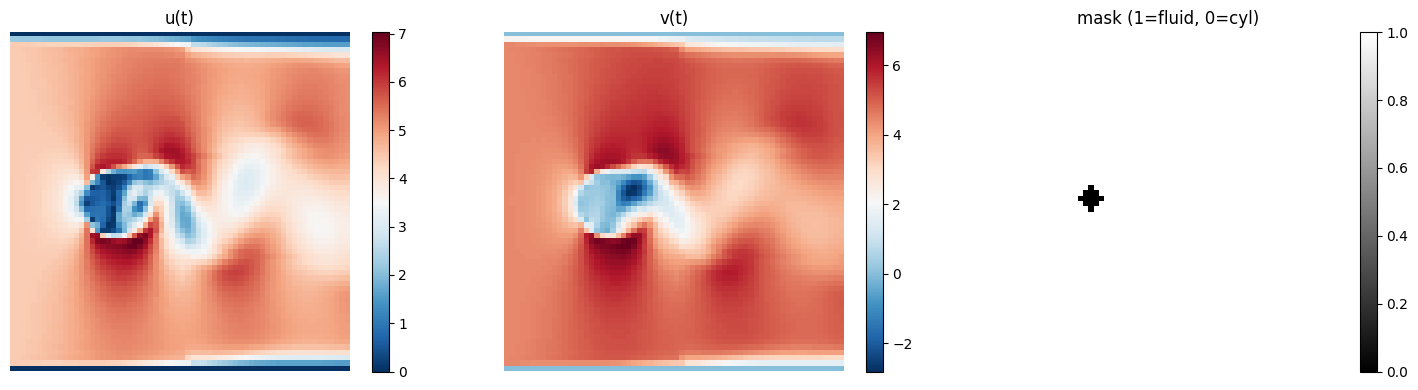

In [38]:
from typing import Dict


def create_geometry_mask(params: Dict) -> np.ndarray:
    """Create binary mask for geometry (1=fluid, 0=cylinder)."""
    H, W = 64, 64
    mask = np.ones((H, W), dtype=np.float32)

    radius = params["radius"]
    x_min = params["x_min"]
    x_max = params["x_max"]
    y_min = params["y_min"]
    y_max = params["y_max"]

    domain_width = x_max - x_min
    domain_height = y_max - y_min

    center_x_rel = 0.0 - x_min
    center_y_rel = (y_max + y_min) / 2 - y_min

    center_x_grid = int((center_x_rel / domain_width) * W)
    center_y_grid = int((center_y_rel / domain_height) * H)
    radius_grid = int((radius / domain_width) * W)

    y_coords, x_coords = np.ogrid[:H, :W]
    dist_from_center = np.sqrt(
        (x_coords - center_x_grid) ** 2 + (y_coords - center_y_grid) ** 2
    )
    mask[dist_from_center <= radius_grid] = 0.0
    return mask


# Pick one example to visualize
case_idx = 0
t = 600

u = bc_train_data.u_data[case_idx]
v = bc_train_data.v_data[case_idx]
params = bc_train_data.case_params[case_idx]
mask = create_geometry_mask(params)

u_t = u[t]
v_t = v[t]

print("Case:", bc_train_data.case_names[case_idx])
print("params:", params)
print("u_t shape:", u_t.shape, "v_t shape:", v_t.shape, "mask shape:", mask.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(u_t, origin="lower", cmap="RdBu_r")
axes[0].set_title("u(t)")
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046)

axes[1].imshow(v_t, origin="lower", cmap="RdBu_r")
axes[1].set_title("v(t)")
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046)

axes[2].imshow(mask, cmap="gray", origin="lower")
axes[2].set_title("mask (1=fluid, 0=cyl)")
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046)

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [39]:
# --- UNet model definition (copied from UNet.ipynb) ---

from typing import List, Optional


class DoubleConv(nn.Module):
    """Double convolution block with replicate padding and bias"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                mid_channels,
                kernel_size=3,
                padding=1,
                bias=True,
                padding_mode="replicate",
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=True,
                padding_mode="replicate",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        in_channels: int = 11,
        out_channels: int = 2,
        features: List[int] = [64, 128, 256, 512],
        n_case_params: int = 9,
        insert_case_params_at: str = "hidden",
        bilinear: bool = False,
        use_residual: bool = True,
        use_output_mask: bool = True,
    ):
        super().__init__()
        assert insert_case_params_at in ["input", "hidden"]

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_case_params = n_case_params
        self.insert_case_params_at = insert_case_params_at
        self.bilinear = bilinear
        self.use_residual = use_residual
        self.use_output_mask = use_output_mask

        if insert_case_params_at == "hidden":
            self.case_params_fc = nn.Linear(n_case_params, features[-1] * 2)

        if insert_case_params_at == "input":
            self.in_conv = DoubleConv(in_channels + 1 + n_case_params, features[0])
        else:
            self.in_conv = DoubleConv(in_channels + 1, features[0])  # +1 for mask

        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        factor = 2 if bilinear else 1
        self.down4 = Down(features[3], features[3] * 2 // factor)

        self.up1 = Up(features[3] * 2, features[3] // factor, bilinear)
        self.up2 = Up(features[3], features[2] // factor, bilinear)
        self.up3 = Up(features[2], features[1] // factor, bilinear)
        self.up4 = Up(features[1], features[0], bilinear)

        self.out_conv = OutConv(features[0], out_channels)

    def forward(
        self,
        x: torch.Tensor,
        case_params: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        # Accept channels-last or channels-first
        if len(x.shape) == 4 and (x.shape[-1] == 11 or x.shape[-1] == 2):
            x = x.permute(0, 3, 1, 2)  # [B,H,W,C] -> [B,C,H,W]

        batch_size, _, height, width = x.shape

        residual = x[:, : self.out_channels] if self.use_residual else None

        # Mask
        if mask is None:
            mask = torch.ones((batch_size, height, width), device=x.device, dtype=x.dtype)
        else:
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)  # [B,1,H,W]
            elif mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)

        mask_input = mask if mask.dim() == 4 else mask.unsqueeze(1)
        x = torch.cat([x, mask_input], dim=1)  # [B, C+1, H, W]

        # Optional params at input
        if self.insert_case_params_at == "input" and case_params is not None:
            case_params = case_params.unsqueeze(2).unsqueeze(3)  # [B,n,1,1]
            case_params = case_params.expand(-1, -1, height, width)
            x = torch.cat([x, case_params], dim=1)

        # Encoder
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Hidden conditioning
        if self.insert_case_params_at == "hidden" and case_params is not None:
            conds = self.case_params_fc(case_params).unsqueeze(2).unsqueeze(3)
            x5 = x5 + conds

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        preds = self.out_conv(x)  # [B,2,H,W]

        if self.use_residual and residual is not None:
            preds = preds + residual

        if self.use_output_mask:
            mask_out = mask.squeeze(1) if mask.dim() == 4 else mask
            if mask_out.dim() == 2:
                mask_out = mask_out.unsqueeze(0)
            preds = preds * mask_out.unsqueeze(1)

        preds = preds.permute(0, 2, 3, 1)  # [B,H,W,2]
        return preds


Loaded checkpoint: checkpoints/10Step.pth
epoch: 49 train_loss: 0.02608580320605507


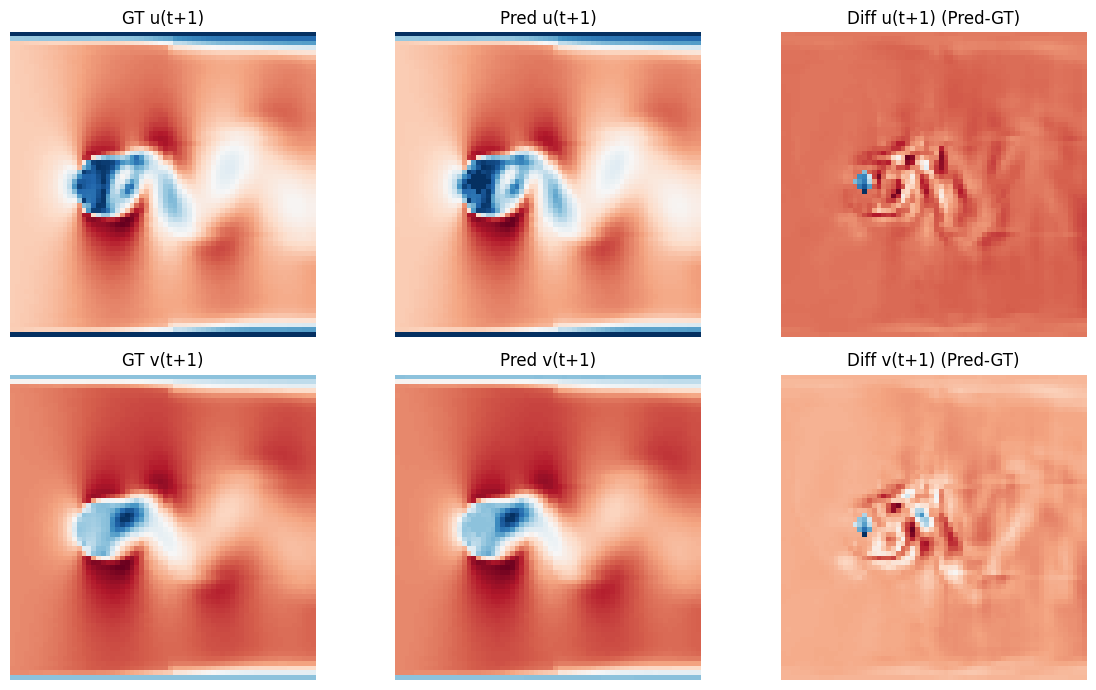

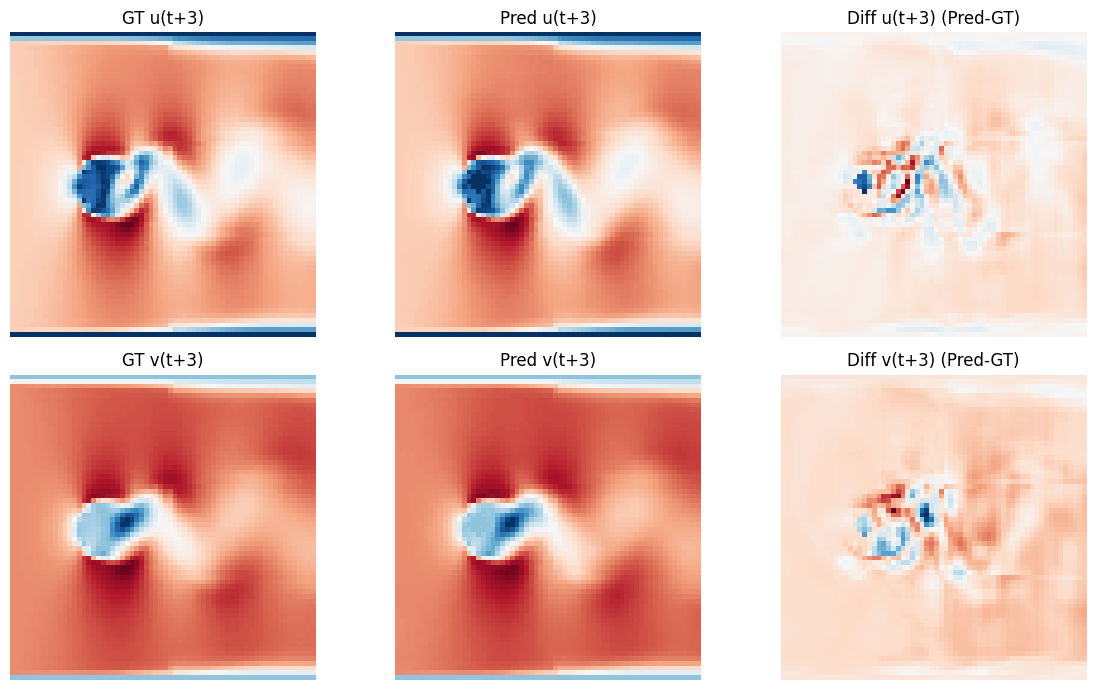

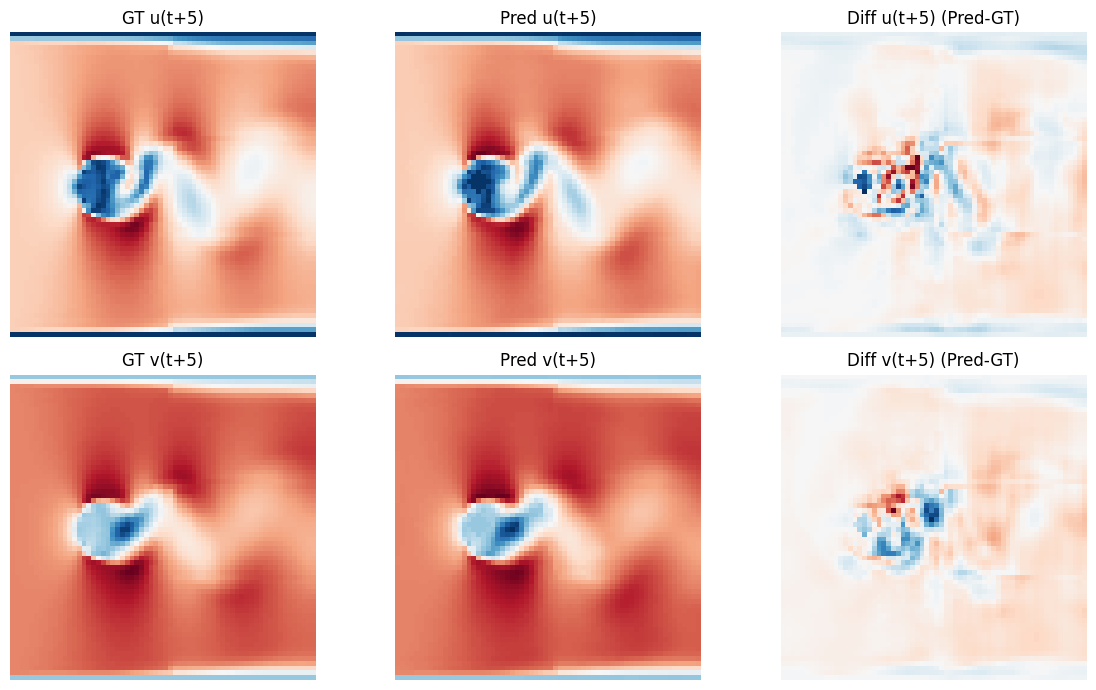

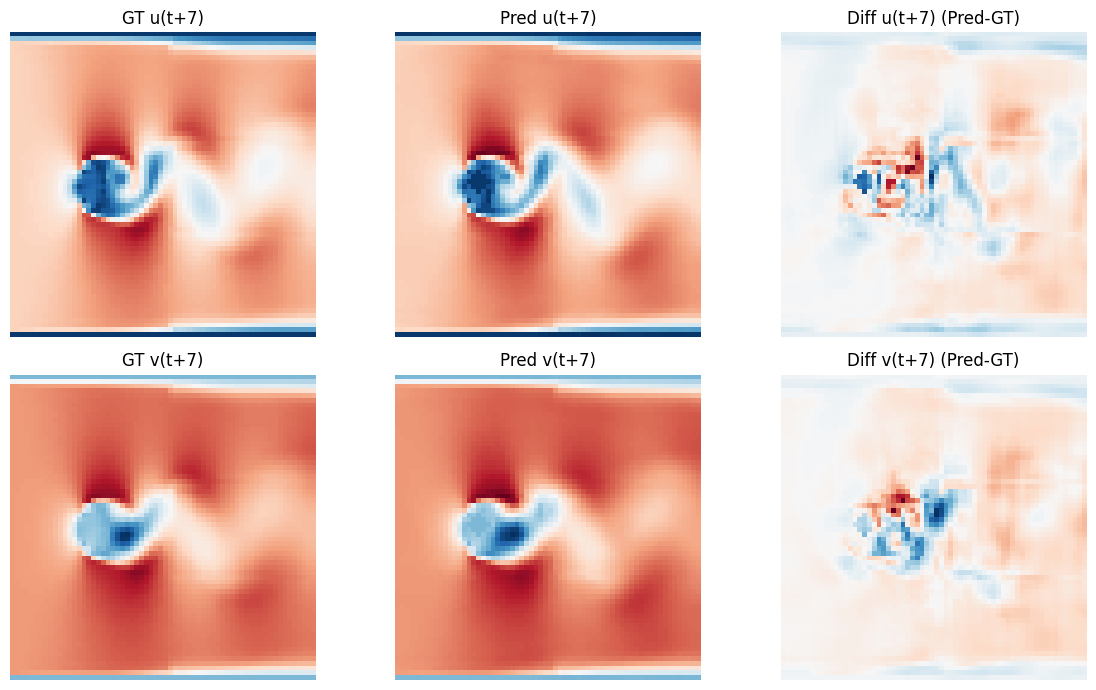

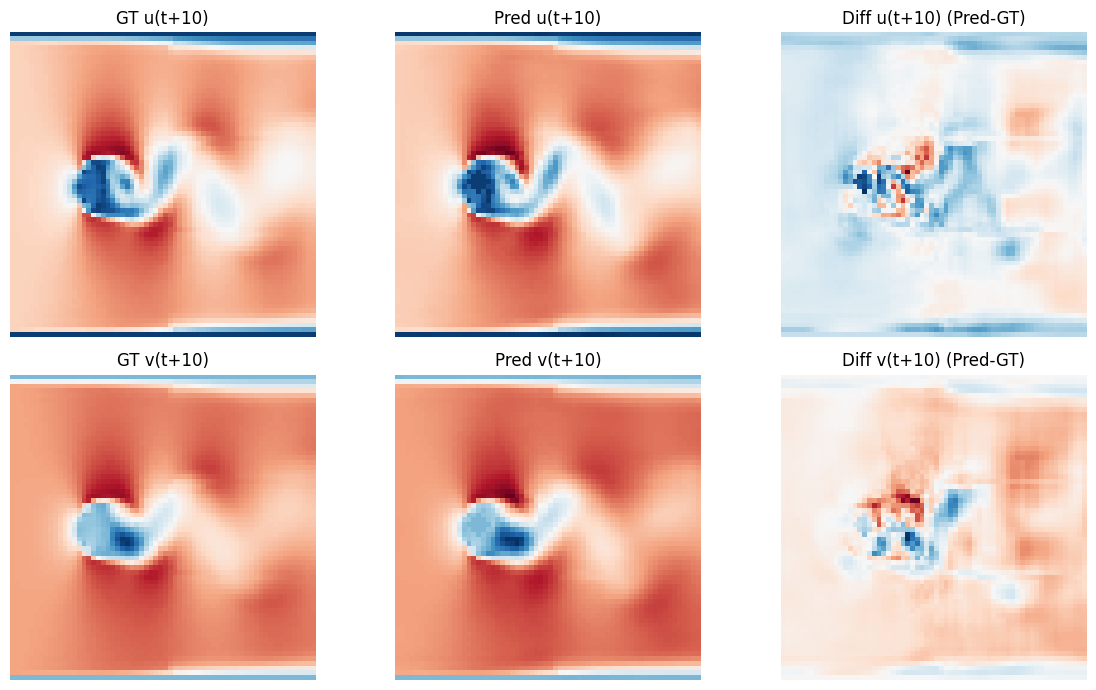

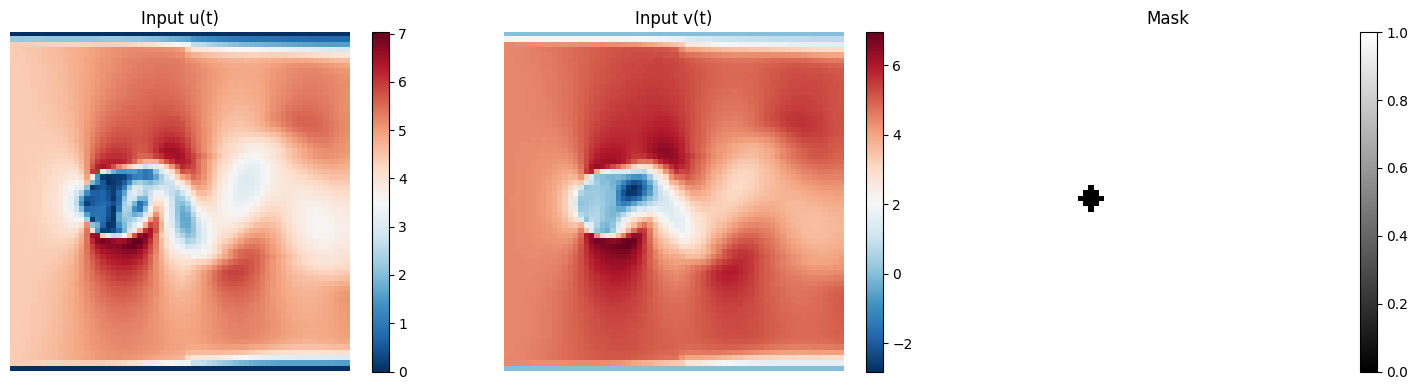

In [41]:
# Load latest weights and run a 10-step autoregressive rollout on the visualized sample

ckpt_path = Path("checkpoints/10Step.pth")
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path.resolve()}"

# Build model exactly like training
model = UNet(
    in_channels=2,
    out_channels=2,
    features=[64, 128, 256, 512],
    n_case_params=8,
    insert_case_params_at="hidden",
    bilinear=False,
    use_residual=True,
    use_output_mask=True,
)

checkpoint = torch.load(ckpt_path, map_location="cpu")
state_dict = (
    checkpoint["model_state_dict"]
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint
    else checkpoint
)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Loaded checkpoint:", ckpt_path)
if isinstance(checkpoint, dict):
    print("epoch:", checkpoint.get("epoch"), "train_loss:", checkpoint.get("train_loss"))

# Prepare tensors
velocities = np.stack([u_t, v_t], axis=-1).astype(np.float32)  # [H,W,2]
case_params = np.array(
    [
        params["vel_in"],
        params["density"],
        params["viscosity"],
        params["radius"] * 2,
        params["x_min"],
        params["x_max"],
        params["y_min"],
        params["y_max"],
    ],
    dtype=np.float32,
)

vel_t = torch.from_numpy(velocities).unsqueeze(0).to(device)  # [1,H,W,2]
case_t = torch.from_numpy(case_params).unsqueeze(0).to(device)  # [1,8]
mask_t = torch.from_numpy(mask).unsqueeze(0).to(device)  # [1,H,W]

# Autoregressive rollout
rollout_steps = 10
preds = []
cur = vel_t.clone()
with torch.inference_mode():
    for _ in range(rollout_steps):
        cur = model(cur, case_params=case_t, mask=mask_t)  # [1,H,W,2]
        preds.append(cur[0].cpu().numpy())

assert t + rollout_steps < u.shape[0], "Not enough timesteps in this case for 10-step rollout"

# Plot a few intermediate horizons to see error growth
steps_to_plot = [1, 3,5,7, 10]
steps_to_plot = [k for k in steps_to_plot if k <= rollout_steps]

for k in steps_to_plot:
    pred_k = preds[k - 1]
    u_true_k = u[t + k]
    v_true_k = v[t + k]

    fig, axes = plt.subplots(2, 3, figsize=(12, 7))

    # u @ t+k
    vmin_u = min(u_true_k.min(), pred_k[..., 0].min())
    vmax_u = max(u_true_k.max(), pred_k[..., 0].max())
    axes[0, 0].imshow(u_true_k, origin="lower", vmin=vmin_u, vmax=vmax_u, cmap="RdBu_r")
    axes[0, 0].set_title(f"GT u(t+{k})")
    axes[0, 1].imshow(pred_k[..., 0], origin="lower", vmin=vmin_u, vmax=vmax_u, cmap="RdBu_r")
    axes[0, 1].set_title(f"Pred u(t+{k})")
    diff_u = pred_k[..., 0] - u_true_k
    axes[0, 2].imshow(diff_u, origin="lower", cmap="RdBu_r")
    axes[0, 2].set_title(f"Diff u(t+{k}) (Pred-GT)")

    # v @ t+k
    vmin_v = min(v_true_k.min(), pred_k[..., 1].min())
    vmax_v = max(v_true_k.max(), pred_k[..., 1].max())
    axes[1, 0].imshow(v_true_k, origin="lower", vmin=vmin_v, vmax=vmax_v, cmap="RdBu_r")
    axes[1, 0].set_title(f"GT v(t+{k})")
    axes[1, 1].imshow(pred_k[..., 1], origin="lower", vmin=vmin_v, vmax=vmax_v, cmap="RdBu_r")
    axes[1, 1].set_title(f"Pred v(t+{k})")
    diff_v = pred_k[..., 1] - v_true_k
    axes[1, 2].imshow(diff_v, origin="lower", cmap="RdBu_r")
    axes[1, 2].set_title(f"Diff v(t+{k}) (Pred-GT)")

    for axrow in axes:
        for ax in axrow:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Also show the input used for rollout
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(u_t, origin="lower", cmap="RdBu_r")
axes[0].set_title("Input u(t)")
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046)

axes[1].imshow(v_t, origin="lower", cmap="RdBu_r")
axes[1].set_title("Input v(t)")
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046)

axes[2].imshow(mask, origin="lower", cmap="gray")
axes[2].set_title("Mask")
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046)

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()
